In [3]:
using Plots
gr()

Plots.GRBackend()

In [4]:
"""
    value_iteration(
        return_function,  # Return for transitioning from current to next state
        state_space,      # Vector of possible states
        discount_factor;  # Discount factor β ∈ (0,1)
        tolerance=1e-2,
        max_iterations=100
    )

Performs value function iteration for a problem where agent directly chooses next state.

Parameters:
- return_function: Function(current_state, next_state) -> reward
- state_space: Vector of possible states
- discount_factor: Discount factor β ∈ (0,1)
- tolerance: Convergence tolerance
- max_iterations: Maximum number of iterations

Returns:
- value_function: Dictionary mapping states to values
- policy: Dictionary mapping states to optimal next states
- iterations: Number of iterations until convergence
"""
function value_iteration(
    return_function,
    state_space,
    discount_factor;
    tolerance=1e-6,
    max_iterations=1000
)
    # Initialize value function
    value_function = Dict(s => 0.0 for s in state_space)
    policy = Dict(s => s for s in state_space)  # Initial policy: stay at current state
    
    for iter in 1:max_iterations
        max_diff = 0.0
        value_function_new = Dict()
        
        # Update value for each current state
        for current_state in state_space
            # Find maximum value over all possible next states
            values = Float64[]
            
            # Try each possible next state
            for next_state in state_space
                # Calculate value of choosing this next state:
                # Current reward + discounted future value
                value = return_function(current_state, next_state) + 
                       discount_factor * value_function[next_state]
                push!(values, value)
            end
            
            # Update value function and policy
            max_value, max_index = findmax(values)
            value_function_new[current_state] = max_value
            policy[current_state] = state_space[max_index]
            
            # Track maximum change
            max_diff = max(max_diff, abs(value_function_new[current_state] - 
                                       value_function[current_state]))
        end
        
        # Check for convergence
        if max_diff < tolerance
            return value_function_new, policy, iter
        end
        
        value_function = value_function_new
    end
    
    @warn "Maximum iterations reached without convergence"
    return value_function, policy, max_iterations
end

value_iteration

In [5]:
function optimal_growth_1(k, k_next)
    # production function: f(k) = Ak^α
    α = 0.33
    A = 1
    δ = 1
    
    # Current production
    production = A*k^α
    
    # Investment needed to reach k_next
    investment = k_next - (1-δ)*k  # δ is depreciation rate
    
    # Consumption is production minus investment
    consumption = production - investment
    
    # Return negative infinity for infeasible transitions
    if consumption <= 0
        return -Inf
    end
    
    # Utility from consumption
    return log(consumption)
end

optimal_growth_1 (generic function with 1 method)

In [6]:
# Function to plot results
function plot_solution(state_space, value_function, policy; 
    true_value_fn=nothing, true_policy_fn=nothing)
# Convert dictionary results to arrays for plotting
value_array = [value_function[s] for s in state_space]
policy_array = [policy[s] for s in state_space]

# Create figure with two subplots
p1 = plot(xlabel="State", title="Value Function", legend=:bottomright)
p2 = plot(xlabel="State", title="Policy Function", legend=:bottomright)

# Plot numerical solutions
plot!(p1, state_space, value_array, label="Numerical", linewidth=2)
plot!(p2, state_space, policy_array, label="Numerical", linewidth=2)

# If true functions are provided, plot them
if true_value_fn !== nothing
true_values = true_value_fn.(state_space)
plot!(p1, state_space, true_values, label="Analytical", 
linestyle=:dash, linewidth=2)
end

if true_policy_fn !== nothing
true_policies = true_policy_fn.(state_space)
plot!(p2, state_space, true_policies, label="Analytical", 
linestyle=:dash, linewidth=2)
end

# Combine plots
plot(p1, p2, layout=(2,1), size=(800,800))
end

plot_solution (generic function with 1 method)

In [7]:
# Set up and solve the problem
k_min_1, k_max_1 = 0.1, 1
state_space_1 = range(k_min_1, k_max_1, length=500)
discount_factor = 0.96

# Solve the problem
value_function_1, policy_1, iterations = value_iteration(
    optimal_growth_1,
    state_space_1,
    discount_factor
)

(Dict{Any, Any}(0.707815631262525 => -23.016528010625986, 0.9332665330661323 => -22.882970725838227, 0.7402805611222445 => -22.99487117228884, 0.7276553106212424 => -23.00318078143208, 0.5995991983967935 => -23.096674434907893, 0.7114228456913828 => -23.014075590767618, 0.556312625250501 => -23.132873407260345, 0.1432865731462926 => -23.78807435326032, 0.6086172344689379 => -23.0894655101137, 0.9801603206412826 => -22.859294140180772…), Dict(0.707815631262525 => 0.2821643286573146, 0.9332665330661323 => 0.3092184368737475, 0.7402805611222445 => 0.2875751503006012, 0.7276553106212424 => 0.28577154308617236, 0.5995991983967935 => 0.26773547094188377, 0.7114228456913828 => 0.2821643286573146, 0.556312625250501 => 0.2605210420841683, 0.1432865731462926 => 0.16673346693386773, 0.6086172344689379 => 0.2695390781563126, 0.9801603206412826 => 0.31462925851703405…), 339)

In [9]:
"""
Calculate analytical solutions for value and policy functions when:
- Policy function: k' = [βbAk^α]/[1 + βb]
- Value function: v(k) = a + b*ln(k)
where:
- b = α/(1-αβ)
- a = [ln(A(1-αβ)) + (αβ/(1-αβ))ln(Aαβ)]/(1-β)
"""
function get_analytical_solutions(;
    α=0.33,    # Capital share
    β=0.96,   # Discount factor
    A=1.0     # Technology parameter
)
    # Calculate b
    b = α/(1 - α*β)
    
    # Calculate a
    term1 = log(A*(1 - α*β))
    term2 = (α*β/(1 - α*β)) * log(A*α*β)
    a = (term1 + term2)/(1 - β)
    
    # Define policy function
    function true_policy(k)
        return (β*b*A*k^α)/(1 + β*b)
    end
    
    # Define value function
    function true_value(k)
        return a + b*log(k)
    end
    
    return true_policy, true_value, (a=a, b=b)
end

# Get analytical solutions
true_policy_1, true_value_1, params = get_analytical_solutions(
    α=0.33, 
    β=0.96, 
    A=1
)

(var"#true_policy#27"{Float64, Float64, Int64, Float64}(0.33, 0.96, 1, 0.48302107728337235), var"#true_value#28"{Float64, Float64}(-22.849598088940862, 0.48302107728337235), (a = -22.849598088940862, b = 0.48302107728337235))

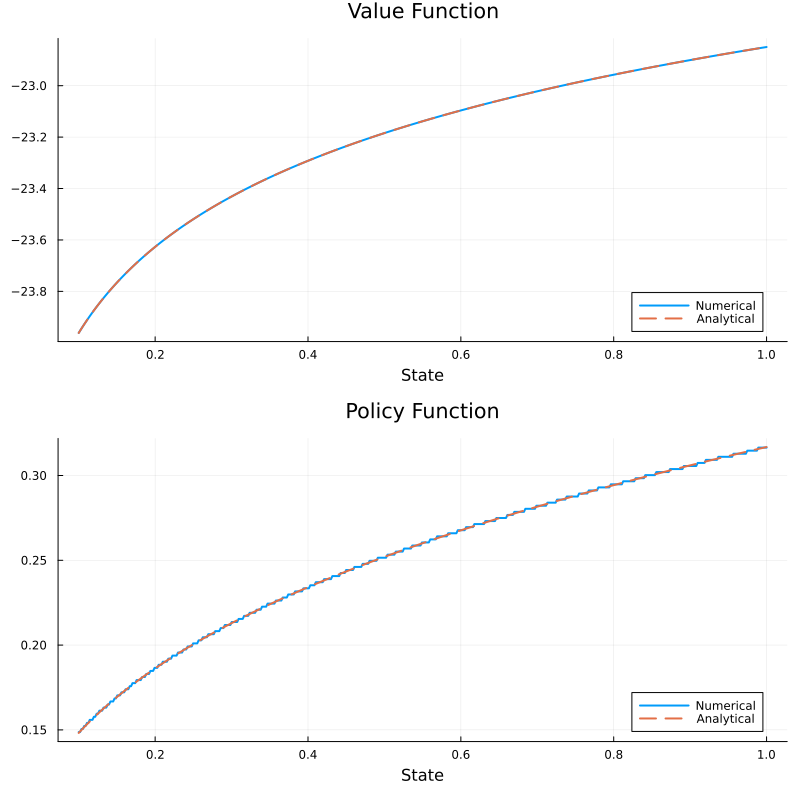

In [10]:
# Plot the results
# You can add your analytical solutions here by replacing `nothing` with actual functions
p = plot_solution(
    state_space_1, 
    value_function_1, 
    policy_1,
    true_value_fn = true_value_1,
    true_policy_fn = true_policy_1
)

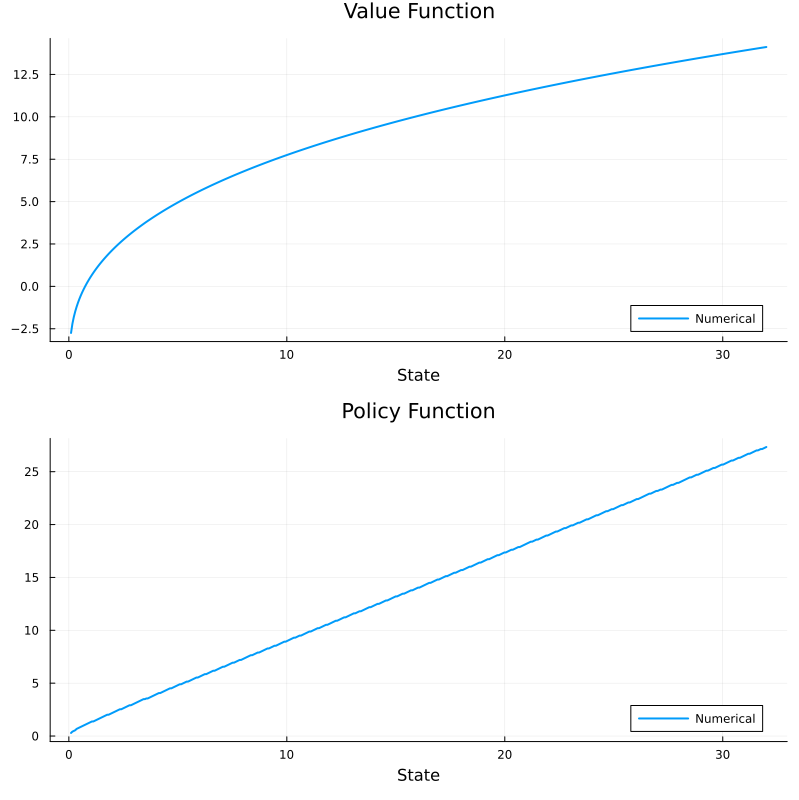

In [11]:
function optimal_growth_2(k, k_next)
    # production function: f(k) = Ak^α
    α = 0.33
    A = 1
    δ = 0.1
    
    # Current production
    production = A*k^α
    
    # Investment needed to reach k_next
    investment = k_next - (1-δ)*k  # δ is depreciation rate
    
    # Consumption is production minus investment
    consumption = production - investment
    
    # Return negative infinity for infeasible transitions
    if consumption <= 0
        return -Inf
    end
    
    # Utility from consumption
    return log(consumption)
end

# Set up and solve the problem
k_min_1, k_max_2 = 0.1, 32
state_space_2 = range(k_min_1, k_max_2, length=500)
discount_factor = 0.96

# Solve the problem
value_function_2, policy_2, iterations = value_iteration(
    optimal_growth_2,
    state_space_2,
    discount_factor
)

# Plot the results
# You can add your analytical solutions here by replacing `nothing` with actual functions
p = plot_solution(
    state_space_2, 
    value_function_2, 
    policy_2
)